Import các thư viên cần thiết


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
from numpy import array
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

MBB Bank Data

In [4]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    return data

In [6]:
# 2. Đọc file csv và gắn index với giá Price
df = read_file('../Dataset/MBB Historical Data.csv')
df1=df.reset_index()['Price']
df1

0       10696.2
1       10595.5
2       10615.6
3       10535.0
4       11058.8
         ...   
1550    24750.0
1551    25050.0
1552    24700.0
1553    25250.0
1554    25300.0
Name: Price, Length: 1555, dtype: float64

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.16260875],
       [0.15791632],
       [0.15885294],
       ...,
       [0.8151593 ],
       [0.84078825],
       [0.84311816]])

MBB 9:1

In [8]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
# 8. Define GRU Model
model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Sử dụng lớp Input để chỉ định hình dạng đầu vào
model.add(GRU(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.1564
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0196
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0058
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.0958e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.7017e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.1546e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.6721e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.2259e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.4533e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.7559e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.0726e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.8922e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.3753e-04
Epoch 15/100
21/2

In [19]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [20]:
# 11. Chuẩn hóa dữ liệu y_pred,
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [22]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

MAE: 22815.830262820462
MAPE: 31305.440416182737
Testing RMSE: 22864.10711707477


In [27]:
def forcast_30Day():
    x_input=test_data[60:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 95
    i=0
    while(i<30):

        if(len(temp_input)> 95):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict30days'])
    plt.show()

In [30]:
def forcast_60Day():
    x_input=test_data[55:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<60):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict60days'])
    plt.show() 

In [33]:
def forcast_90Day():
    x_input=test_data[55:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<90):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict90days'])
    plt.show()

96
0 day input [0.51926133 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095
 0.52625104 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218
 0.49596227 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237
 0.5052819  0.5052819  0.5076118  0.51460152 0.51227161 0.50994171
 0.51460152 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171
 0.50994171 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123
 0.52858095 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725
 0.62876687 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545
 0.66604536 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451
 0.6846846  0.6846846  0.68934441 0.69633413 0.69400422 0.67769488
 0.6846846  0.67769488 0.73361261 0.73827242 0.75924157 0.78953034
 0.78254062 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072
 0.78254062 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024
 0.81049949 0.81282939 0.80117986 0.76390138 0.73361261 0.74060233
 0.77555091 0.75691166 0.773221   0.74526214 0.

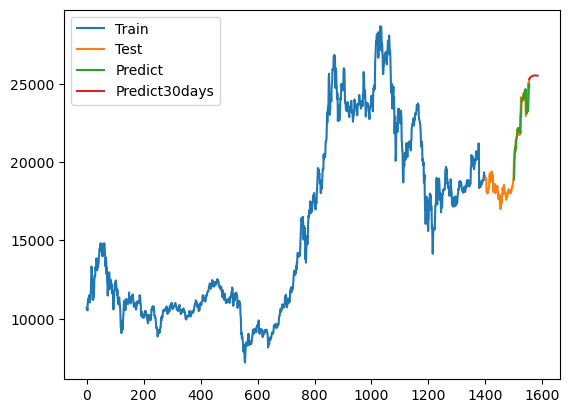

In [28]:
forcast_30Day()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

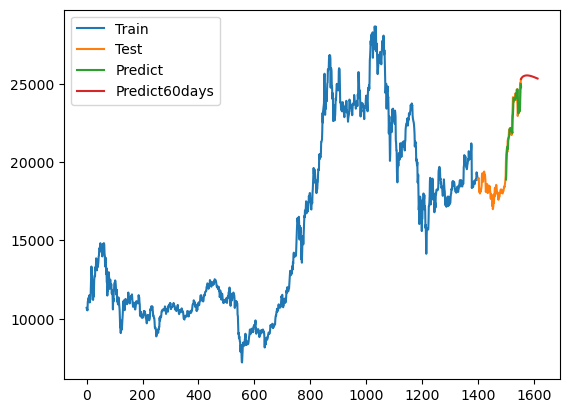

In [31]:
forcast_60Day()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

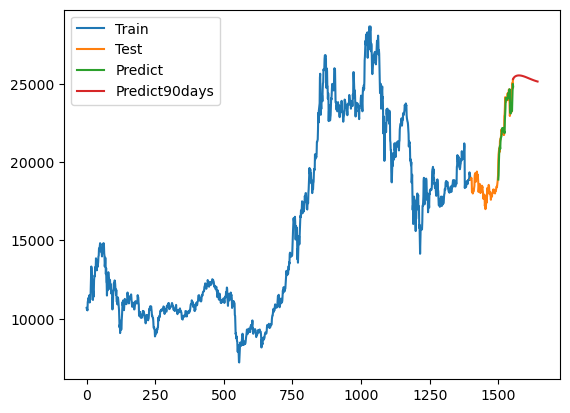

In [34]:
forcast_90Day()

MBB Data 8:2

In [51]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]


311
311


In [52]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [54]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.0018e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.2502e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 3.0303e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.6997e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.8044e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.7391e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.0624e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.2225e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.1600e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 3.0774e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 3.0920e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 3.2053e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.5645e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 2.8940e-04
E

In [55]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [56]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [57]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

MAE: 19903.934944456065
MAPE: 34225.900644980116
Testing RMSE: 20011.93530250726


In [58]:
def forcast_30Day_8():
    x_input=test_data[210:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<30):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict30days'])
    plt.show()

In [63]:
def forcast_60Day_8():
    x_input=test_data[210:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<60):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict60days'])
    plt.show()

In [61]:
def forcast_90Day_8():
    x_input=test_data[210:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<90):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict90days'])
    plt.show()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

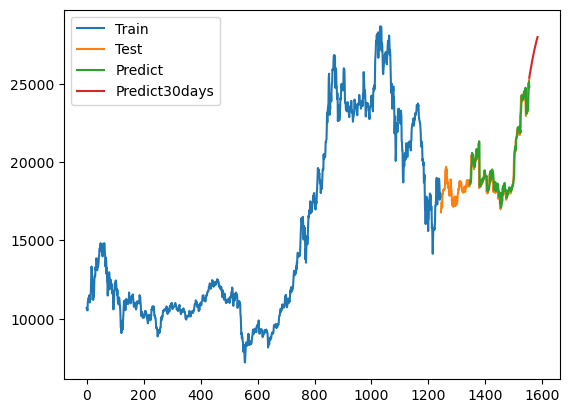

In [59]:
forcast_30Day_8()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

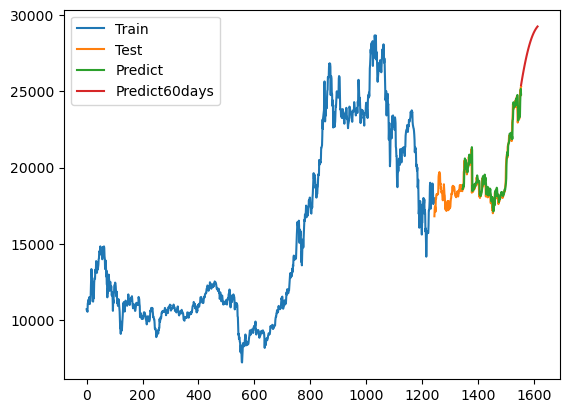

In [64]:
forcast_60Day_8()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

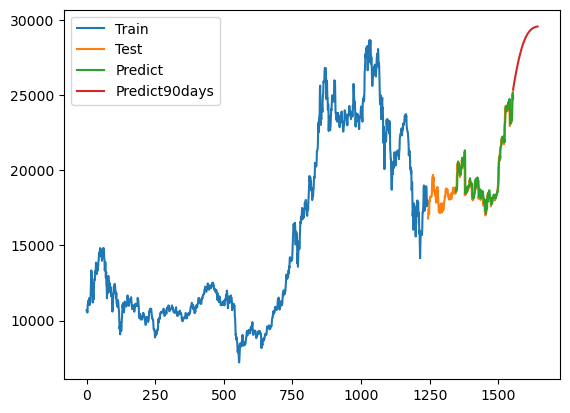

In [65]:
forcast_90Day_8()

MBB Data 7:3

In [86]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1)+1)

train_data = df1[:train_size]
test_data = df1[train_size:]

In [87]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [88]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [89]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 2.5784e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 2.7878e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 2.4449e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 2.1571e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 2.7725e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 2.7601e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 2.2070e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 2.7149e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 2.2559e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 2.4075e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 2.5395e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 2.5074e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 2.5698e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss

In [81]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [82]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [83]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

MAE: 18842.00057994883
MAPE: 34754.35204450291
Testing RMSE: 18940.89698616041


In [84]:
def forcast_30Day_7():
    x_input=test_data[366:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<30):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict30days'])
    plt.show()

In [58]:
def forcast_60Day_7():
    x_input=test_data[366:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 100
    i=0
    while(i<60):

        if(len(temp_input)> 100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict60days'])
    plt.show()

In [59]:
def forcast_90Day_7():
    x_input=test_data[300:].reshape(1,-1)
    x_input.shape
    print(x_input.size)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps= 93
    i=0
    while(i<90):

        if(len(temp_input)> 93):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    # 14.Vẽ hình 
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))

    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))

    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))

    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

    plt.legend(['Train','Test','Predict','Predict90days'])
    plt.show()

101
0 day input [0.46567351 0.48897256 0.47499313 0.50062208 0.49363237 0.51926133
 0.51926133 0.50295199 0.5076118  0.52392114 0.52858095 0.52625104
 0.51227161 0.50295199 0.5076118  0.5052819  0.49829218 0.49596227
 0.48431275 0.49596227 0.49596227 0.49363237 0.49363237 0.5052819
 0.5052819  0.5076118  0.51460152 0.51227161 0.50994171 0.51460152
 0.5052819  0.5052819  0.5052819  0.50295199 0.50994171 0.50994171
 0.50994171 0.51693142 0.52159123 0.52392114 0.52159123 0.52858095
 0.53324076 0.54256038 0.55653981 0.60080801 0.61944725 0.62876687
 0.63575659 0.6380865  0.62643697 0.65905564 0.66371545 0.66604536
 0.66604536 0.67536498 0.69167432 0.69400422 0.68701451 0.6846846
 0.6846846  0.68934441 0.69633413 0.69400422 0.67769488 0.6846846
 0.67769488 0.73361261 0.73827242 0.75924157 0.78953034 0.78254062
 0.78021072 0.77555091 0.78254062 0.78021072 0.78021072 0.78254062
 0.79419015 0.80117986 0.78953034 0.78254062 0.79186024 0.81049949
 0.81282939 0.80117986 0.76390138 0.73361261 0.74

ValueError: x and y must have same first dimension, but have shapes (465,) and (467, 1)

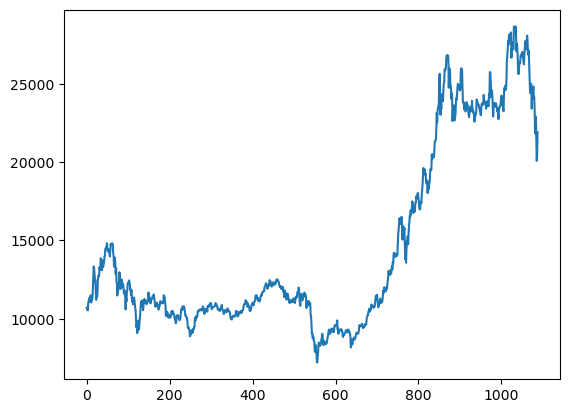

In [85]:
forcast_30Day_7()

94
0 day input [0.49171253 0.49171253 0.49855313 0.50311042 0.50539373 0.50311042
 0.50995103 0.51451298 0.52362757 0.53730877 0.58062171 0.59886021
 0.60797946 0.6148154  0.61709871 0.60570081 0.63761585 0.64217315
 0.6444518  0.6444518  0.65357105 0.6695309  0.67180954 0.66496894
 0.6626903  0.6626903  0.66725225 0.67408819 0.67180954 0.65584969
 0.6626903  0.65584969 0.71056519 0.71512248 0.73563963 0.76527602
 0.75844008 0.75615677 0.75159948 0.75844008 0.75615677 0.75387813
 0.75844008 0.76983798 0.77667392 0.76527602 0.75844008 0.76755467
 0.78579317 0.78579317 0.77667392 0.74020158 0.71056519 0.71740113
 0.75159948 0.73336098 0.74932083 0.72196308 0.72196308 0.76527602
 0.79263377 0.80631032 0.79035512 0.81542956 0.81770821 0.82682746
 0.82227017 0.79947437 0.79491242 0.76755467 0.74932083 0.72880369
 0.73563963 0.75844008 0.74932083 0.74703753 0.78807182 0.73108233
 0.75387813 0.71740113 0.69916729 0.69460534 0.66725225 0.69232669
 0.67865015 0.67865015 0.68548609 0.68548609 0.

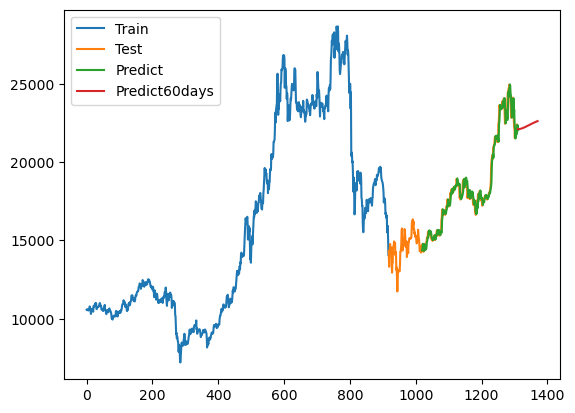

In [61]:
forcast_60Day_7()


94
0 day input [0.49171253 0.49171253 0.49855313 0.50311042 0.50539373 0.50311042
 0.50995103 0.51451298 0.52362757 0.53730877 0.58062171 0.59886021
 0.60797946 0.6148154  0.61709871 0.60570081 0.63761585 0.64217315
 0.6444518  0.6444518  0.65357105 0.6695309  0.67180954 0.66496894
 0.6626903  0.6626903  0.66725225 0.67408819 0.67180954 0.65584969
 0.6626903  0.65584969 0.71056519 0.71512248 0.73563963 0.76527602
 0.75844008 0.75615677 0.75159948 0.75844008 0.75615677 0.75387813
 0.75844008 0.76983798 0.77667392 0.76527602 0.75844008 0.76755467
 0.78579317 0.78579317 0.77667392 0.74020158 0.71056519 0.71740113
 0.75159948 0.73336098 0.74932083 0.72196308 0.72196308 0.76527602
 0.79263377 0.80631032 0.79035512 0.81542956 0.81770821 0.82682746
 0.82227017 0.79947437 0.79491242 0.76755467 0.74932083 0.72880369
 0.73563963 0.75844008 0.74932083 0.74703753 0.78807182 0.73108233
 0.75387813 0.71740113 0.69916729 0.69460534 0.66725225 0.69232669
 0.67865015 0.67865015 0.68548609 0.68548609 0.

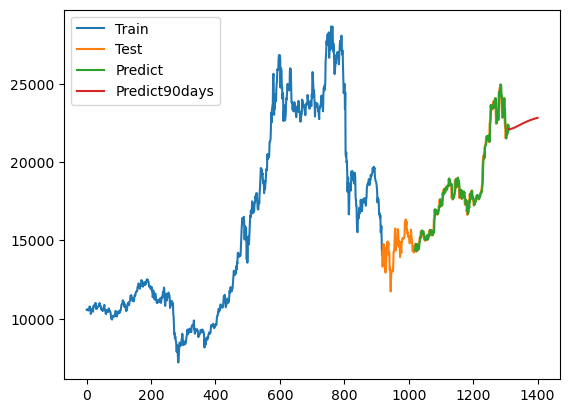

In [62]:
forcast_90Day_7()

<font size = 12>BID</font>

In [63]:
# 2. Đọc file csv và gắn index với giá Price
df = pd.read_csv('../Dataset/BID_Historical_Data.csv')
df1=df.reset_index()['Price']
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [64]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]

In [65]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [66]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [67]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.4899e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.2288e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.7365e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.2339e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0773e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.3730e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.4823e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.3898e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.7838e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.9460e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.9802e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.5700e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.3379e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0593e-04
E

In [68]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred,
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [69]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 50441.486633434804


92
[0.8080937]
93
1 day input [0.61427349 0.63848227 0.6320266  0.6320266  0.62234309 0.64493794
 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797

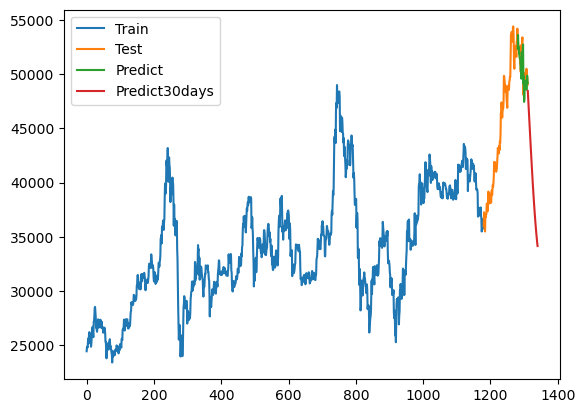

In [70]:
forcast_30Day()

92
[0.8080937]
93
1 day input [0.61427349 0.63848227 0.6320266  0.6320266  0.62234309 0.64493794
 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797

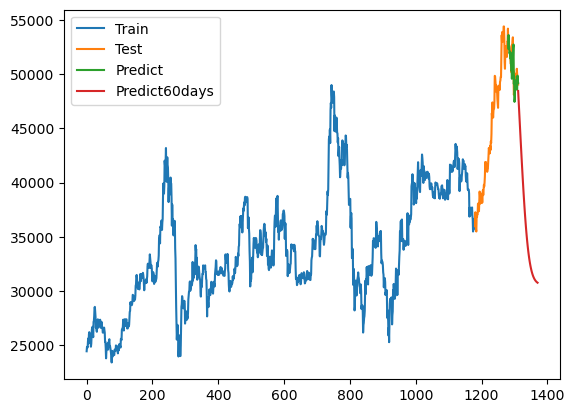

In [71]:
forcast_60Day()

92
[0.8080937]
93
1 day input [0.61427349 0.63848227 0.6320266  0.6320266  0.62234309 0.64493794
 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797

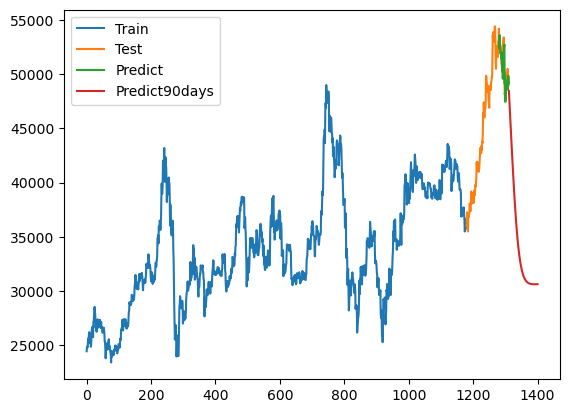

In [72]:
forcast_90Day()

BID 8:2

In [73]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [74]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 6.6764e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.9438e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.5507e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.8143e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.9253e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 7.1520e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.9831e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 6.2453e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.5249e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.0844e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.5099e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.1086e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.8136e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 6.9295e-04
E

In [75]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred,
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [76]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 45084.94463385004


93
0 day input [0.59329255 0.61427349 0.63848227 0.6320266  0.6320266  0.62234309
 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305
 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224
 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897
 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966
 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154
 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731
 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947 1.
 1.         0.96449379 0.89348138 0.87411436 0.92253192 0.94189894
 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028 0.95481028
 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975
 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787
 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869
 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383
 0.83215248 0.83215248 0.83215248 0.87411436 0.85797518

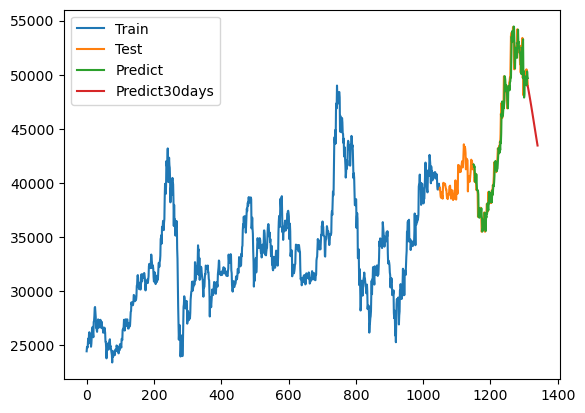

In [77]:
forcast_30Day_8()

93
0 day input [0.59329255 0.61427349 0.63848227 0.6320266  0.6320266  0.62234309
 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305
 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224
 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897
 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966
 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154
 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731
 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947 1.
 1.         0.96449379 0.89348138 0.87411436 0.92253192 0.94189894
 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028 0.95481028
 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975
 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787
 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869
 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383
 0.83215248 0.83215248 0.83215248 0.87411436 0.85797518

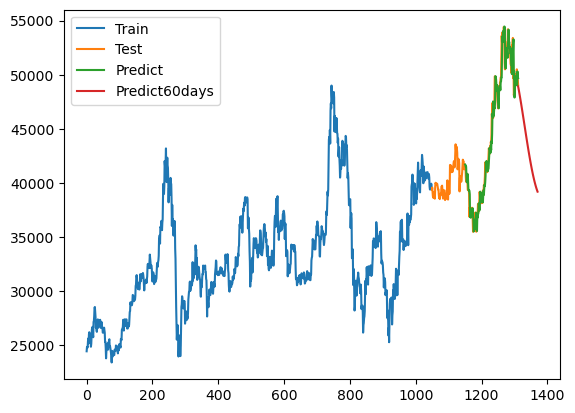

In [78]:
forcast_60Day_8()

93
0 day input [0.59329255 0.61427349 0.63848227 0.6320266  0.6320266  0.62234309
 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415 0.74177305
 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224
 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897
 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966
 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154
 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731
 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947 1.
 1.         0.96449379 0.89348138 0.87411436 0.92253192 0.94189894
 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028 0.95481028
 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975
 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787
 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869
 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383
 0.83215248 0.83215248 0.83215248 0.87411436 0.85797518

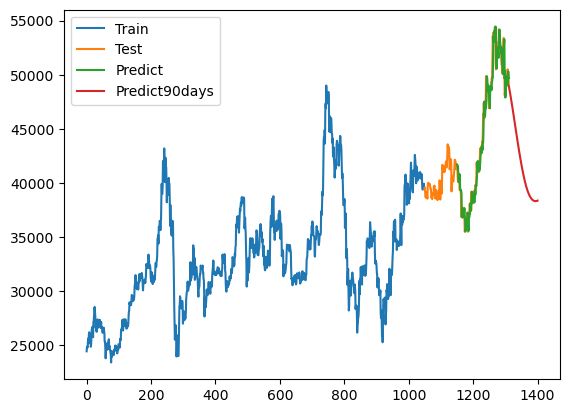

In [79]:
forcast_90Day_8()

BID 7:3

In [80]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [81]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.7366e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.6791e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.6653e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.2012e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.6307e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.3774e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.9180e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.8704e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.9912e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.4685e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.9481e-04
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.7499e-04
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.6138e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.9811e-04
E

In [82]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [83]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 42968.234425289724


94
0 day input [0.57715337 0.59329255 0.61427349 0.63848227 0.6320266  0.6320266
 0.62234309 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415
 0.74177305 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872
 0.75791224 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816
 0.82246897 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493
 0.76920966 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289
 0.81117154 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192
 0.97417731 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947
 1.         1.         0.96449379 0.89348138 0.87411436 0.92253192
 0.94189894 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028
 0.95481028 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894
 0.92575975 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085
 0.88379787 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167
 0.86765869 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518
 0.84506383 0.83215248 0.83215248 0.83215248 0.8

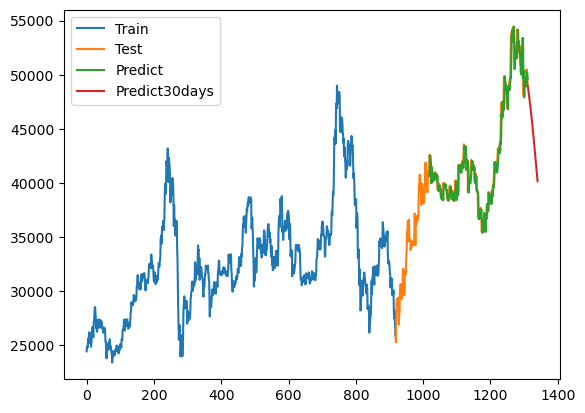

In [84]:
forcast_30Day_7()

94
0 day input [0.57715337 0.59329255 0.61427349 0.63848227 0.6320266  0.6320266
 0.62234309 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415
 0.74177305 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872
 0.75791224 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816
 0.82246897 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493
 0.76920966 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289
 0.81117154 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192
 0.97417731 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947
 1.         1.         0.96449379 0.89348138 0.87411436 0.92253192
 0.94189894 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028
 0.95481028 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894
 0.92575975 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085
 0.88379787 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167
 0.86765869 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518
 0.84506383 0.83215248 0.83215248 0.83215248 0.8

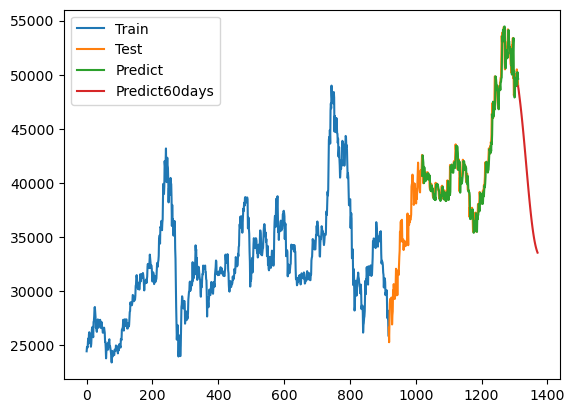

In [85]:
forcast_60Day_7()


94
0 day input [0.57715337 0.59329255 0.61427349 0.63848227 0.6320266  0.6320266
 0.62234309 0.64493794 0.6320266  0.65784929 0.65300754 0.68044415
 0.74177305 0.73047562 0.77405142 0.74500089 0.7288617  0.74822872
 0.75791224 0.75629832 0.77727926 0.85313342 0.8515195  0.83860816
 0.82246897 0.80632979 0.82408289 0.8160133  0.80794371 0.78373493
 0.76920966 0.75791224 0.81439938 0.81924114 0.82408289 0.82408289
 0.81117154 0.83538032 0.83860816 0.84990559 0.84990559 0.92253192
 0.97417731 0.95481028 0.98386082 0.95481028 0.97094947 0.97094947
 1.         1.         0.96449379 0.89348138 0.87411436 0.92253192
 0.94189894 0.9128484  0.92898759 0.92253192 0.90962057 0.95481028
 0.95481028 0.99354433 0.95481028 0.95481028 0.9386711  0.94189894
 0.92575975 0.92575975 0.91930408 0.89025355 0.89025355 0.86443085
 0.88379787 0.94512677 0.92253192 0.95481028 0.96772163 0.84829167
 0.86765869 0.79664628 0.80471587 0.86120301 0.83860816 0.85797518
 0.84506383 0.83215248 0.83215248 0.83215248 0.8

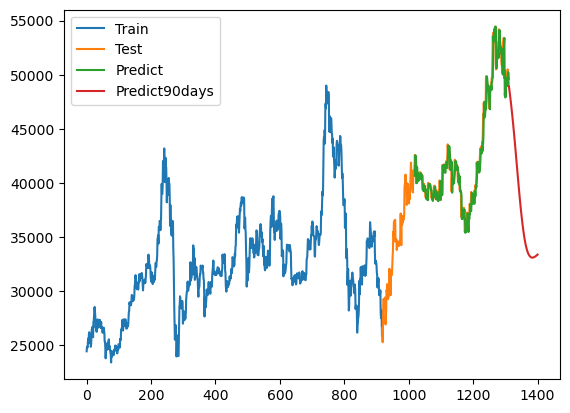

In [86]:
forcast_90Day_7()


<font size = 12 >VCB</font>

In [87]:
# 2. Đọc file csv và gắn index với giá Price
df = pd.read_csv('../Dataset/VCB_Historical_Data.csv')
df1=df.reset_index()['Price']
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

VCB 9:1

In [88]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [89]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.6725e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 6.6320e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.1789e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.6233e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.8130e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.9835e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.8234e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.6015e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0799e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.5411e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.4723e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0740e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.2802e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.9919e-04
E

In [90]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [91]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 93215.16494007542


92
[0.89788055]
93
1 day input [0.6914446  0.70827489 0.72697522 0.72510519 0.72697522 0.6802244
 0.74006545 0.75876578 0.78494624 0.79055633 0.80177653 0.82047686
 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758 0.87844787
 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794 0.88031791
 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751 0.86722768
 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745 0.86535764
 0.885928   0.88405797 0.85226741 0.84104722 0.85226741 0.88218794
 1.         0.99812997 0.99812997 0.97381954 0.96446938 0.96633941
 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954 0.95511921
 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928 0.98129967
 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918 0.95885928
 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918 0.94202899
 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791 0.87096774
 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791 0.88405797
 0.8971482  0.9083684  0.9177185

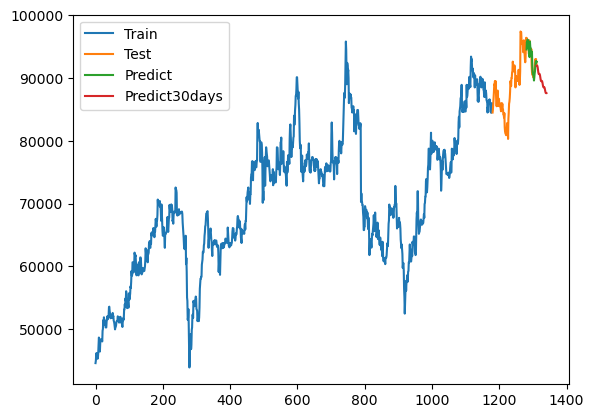

In [92]:
forcast_30Day()

92
[0.89788055]
93
1 day input [0.6914446  0.70827489 0.72697522 0.72510519 0.72697522 0.6802244
 0.74006545 0.75876578 0.78494624 0.79055633 0.80177653 0.82047686
 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758 0.87844787
 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794 0.88031791
 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751 0.86722768
 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745 0.86535764
 0.885928   0.88405797 0.85226741 0.84104722 0.85226741 0.88218794
 1.         0.99812997 0.99812997 0.97381954 0.96446938 0.96633941
 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954 0.95511921
 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928 0.98129967
 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918 0.95885928
 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918 0.94202899
 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791 0.87096774
 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791 0.88405797
 0.8971482  0.9083684  0.9177185

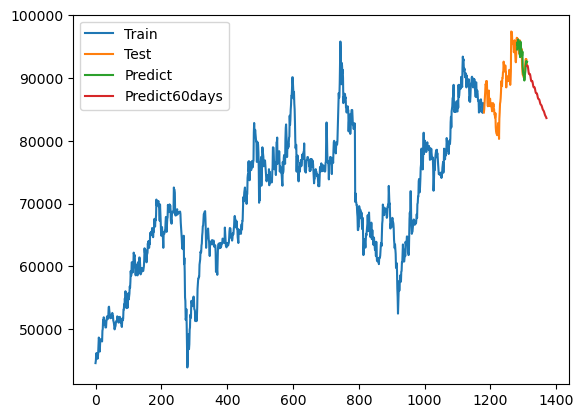

In [93]:
forcast_60Day()

92
[0.89788055]
93
1 day input [0.6914446  0.70827489 0.72697522 0.72510519 0.72697522 0.6802244
 0.74006545 0.75876578 0.78494624 0.79055633 0.80177653 0.82047686
 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758 0.87844787
 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794 0.88031791
 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751 0.86722768
 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745 0.86535764
 0.885928   0.88405797 0.85226741 0.84104722 0.85226741 0.88218794
 1.         0.99812997 0.99812997 0.97381954 0.96446938 0.96633941
 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954 0.95511921
 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928 0.98129967
 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918 0.95885928
 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918 0.94202899
 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791 0.87096774
 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791 0.88405797
 0.8971482  0.9083684  0.9177185

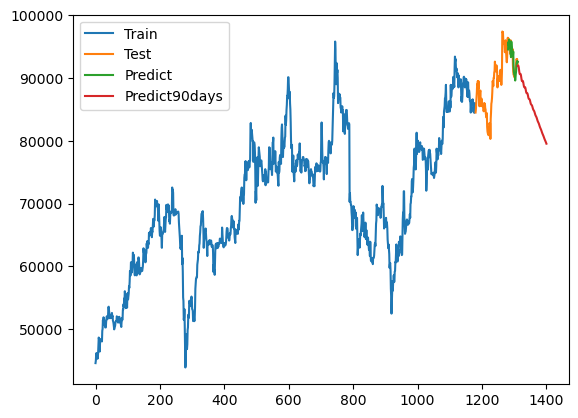

In [94]:
forcast_90Day()

VCB 8:2


In [95]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [96]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 5.8454e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.3817e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.2108e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.9519e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.8758e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0615e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.2247e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.8369e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.7159e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.8477e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.5726e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.1859e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.5921e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.1699e-04
E

In [97]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [98]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 89055.06796553268


93
0 day input [0.6914446  0.6914446  0.70827489 0.72697522 0.72510519 0.72697522
 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633 0.80177653
 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758
 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794
 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751
 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745
 0.86535764 0.885928   0.88405797 0.85226741 0.84104722 0.85226741
 0.88218794 1.         0.99812997 0.99812997 0.97381954 0.96446938
 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954
 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928
 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918
 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918
 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791
 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791
 0.88405797 0.8971482  0.9083684  0.91771856 0.

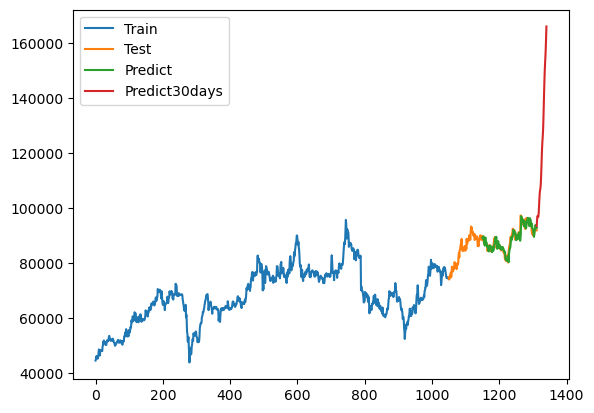

In [99]:
forcast_30Day_8()

93
0 day input [0.6914446  0.6914446  0.70827489 0.72697522 0.72510519 0.72697522
 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633 0.80177653
 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758
 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794
 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751
 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745
 0.86535764 0.885928   0.88405797 0.85226741 0.84104722 0.85226741
 0.88218794 1.         0.99812997 0.99812997 0.97381954 0.96446938
 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954
 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928
 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918
 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918
 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791
 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791
 0.88405797 0.8971482  0.9083684  0.91771856 0.

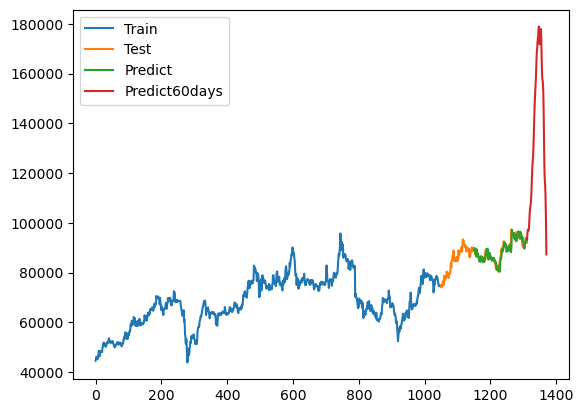

In [100]:
forcast_60Day_8()

93
0 day input [0.6914446  0.6914446  0.70827489 0.72697522 0.72510519 0.72697522
 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633 0.80177653
 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758 0.86161758
 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807 0.88218794
 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709 0.85787751
 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755 0.85413745
 0.86535764 0.885928   0.88405797 0.85226741 0.84104722 0.85226741
 0.88218794 1.         0.99812997 0.99812997 0.97381954 0.96446938
 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902 0.97381954
 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863 0.95885928
 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944 0.95324918
 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918 0.95324918
 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823 0.88031791
 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777 0.88031791
 0.88405797 0.8971482  0.9083684  0.91771856 0.

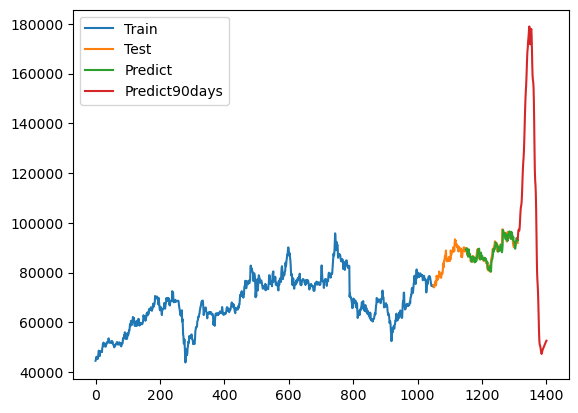

In [101]:
forcast_90Day_8()

VCB 7:3

In [102]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1) + 1)

train_data = df1[:train_size]
test_data = df1[train_size:]
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [103]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 5.6053e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 6.0366e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5.0733e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 5.5979e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5.9288e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 5.4858e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.5327e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 5.5659e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 6.5290e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 5.5182e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.9630e-04
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7457e-04
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 6.4588e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 5.1318e-0

In [104]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [105]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE,MAE and MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print('Testing RMSE:', test_rmse)

Testing RMSE: 85826.6916231094


94
0 day input [0.69518467 0.6914446  0.6914446  0.70827489 0.72697522 0.72510519
 0.72697522 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633
 0.80177653 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758
 0.86161758 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807
 0.88218794 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709
 0.85787751 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755
 0.85413745 0.86535764 0.885928   0.88405797 0.85226741 0.84104722
 0.85226741 0.88218794 1.         0.99812997 0.99812997 0.97381954
 0.96446938 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902
 0.97381954 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863
 0.95885928 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944
 0.95324918 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918
 0.95324918 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823
 0.88031791 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777
 0.88031791 0.88405797 0.8971482  0.9083684  0.

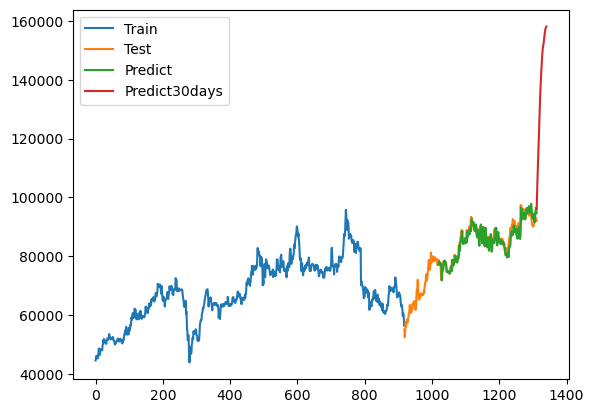

In [106]:
forcast_30Day_7()

94
0 day input [0.69518467 0.6914446  0.6914446  0.70827489 0.72697522 0.72510519
 0.72697522 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633
 0.80177653 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758
 0.86161758 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807
 0.88218794 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709
 0.85787751 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755
 0.85413745 0.86535764 0.885928   0.88405797 0.85226741 0.84104722
 0.85226741 0.88218794 1.         0.99812997 0.99812997 0.97381954
 0.96446938 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902
 0.97381954 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863
 0.95885928 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944
 0.95324918 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918
 0.95324918 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823
 0.88031791 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777
 0.88031791 0.88405797 0.8971482  0.9083684  0.

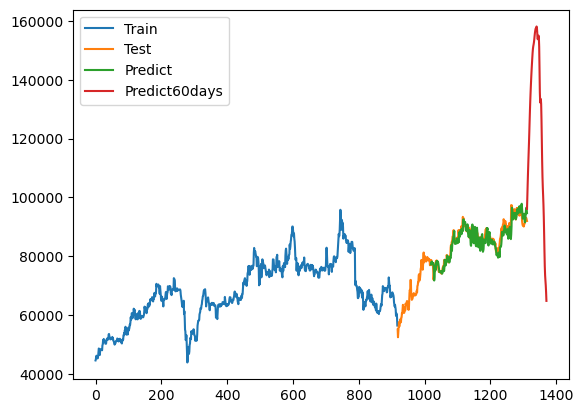

In [107]:
forcast_60Day_7()

94
0 day input [0.69518467 0.6914446  0.6914446  0.70827489 0.72697522 0.72510519
 0.72697522 0.6802244  0.74006545 0.75876578 0.78494624 0.79055633
 0.80177653 0.82047686 0.85226741 0.84852735 0.83730715 0.86161758
 0.86161758 0.87844787 0.88218794 0.91023843 0.89901823 0.88966807
 0.88218794 0.88031791 0.89901823 0.88405797 0.88031791 0.83356709
 0.85787751 0.86722768 0.86161758 0.85226741 0.86161758 0.85974755
 0.85413745 0.86535764 0.885928   0.88405797 0.85226741 0.84104722
 0.85226741 0.88218794 1.         0.99812997 0.99812997 0.97381954
 0.96446938 0.96633941 0.97007948 0.95698925 0.93828892 0.94389902
 0.97381954 0.95511921 0.93641889 0.91771856 0.9083684  0.92145863
 0.95885928 0.98129967 0.96820944 0.97942964 0.97007948 0.96820944
 0.95324918 0.95885928 0.94576905 0.93267882 0.97381954 0.95324918
 0.95324918 0.94202899 0.94576905 0.93641889 0.94763908 0.89901823
 0.88031791 0.87096774 0.87096774 0.87283777 0.86348761 0.87283777
 0.88031791 0.88405797 0.8971482  0.9083684  0.

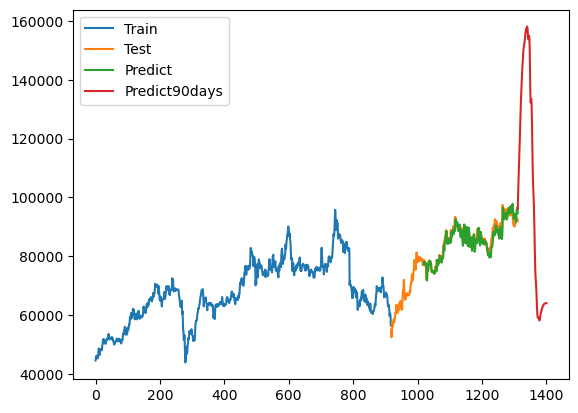

In [108]:
forcast_90Day_7()